Start final year project

In [1]:
import os
from pathlib import Path
import glob

import pandas as pd
import dask.bag as db
import dask.array as da
from dask.diagnostics import ProgressBar

import cv2
from PIL import Image
import numpy as np
from skimage import feature

import random
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

plt.style.use("dark_background")

Download kaggle data


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/parkinsons-drawings")

print("Path to dataset files:", path)

100%|██████████| 41.4M/41.4M [00:00<00:00, 147MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/parkinsons-drawings/versions/1


In [5]:
data = '/root/.cache/kagglehub/datasets/kmader/parkinsons-drawings/versions/1'

paths = [path.parts[-2:] for path in
         Path(data).rglob('*.*')]                             #writing purpose ('*.*') so that all image formats can be retrieved
df = pd.DataFrame(data=paths, columns=['Class','Images'])     #create column names for dataframe
df = df.sort_values('Class',ascending=True)                   #sort class name
df.reset_index(drop=True, inplace=True)                       #sort index of each row
df                                                            #display dataframe

Class       Images
0      healthy  V55HE10.png
1      healthy  V07HO03.png
2      healthy  V01HO02.png
3      healthy  V55HO12.png
4      healthy  V06HO02.png
..         ...          ...
403  parkinson  V03PO04.png
404  parkinson  V14PO01.png
405  parkinson  V08PO01.png
406  parkinson  V13PO03.png
407  parkinson  V03PO07.png

[408 rows x 2 columns]

count images

In [6]:
print('Count the number of image datasets')
print("Image Count : {}".format(len(df.Images)))
print("Class Count : {} \n".format(len(df['Class'].value_counts())))
print('Count the number of images in each class')
print(df['Class'].value_counts())

Count the number of image datasets
Image Count : 408
Class Count : 2 

Count the number of images in each class
Class
healthy      204
parkinson    204
Name: count, dtype: int64


graph of image for each section

Text(0, 0.5, 'Count Image')

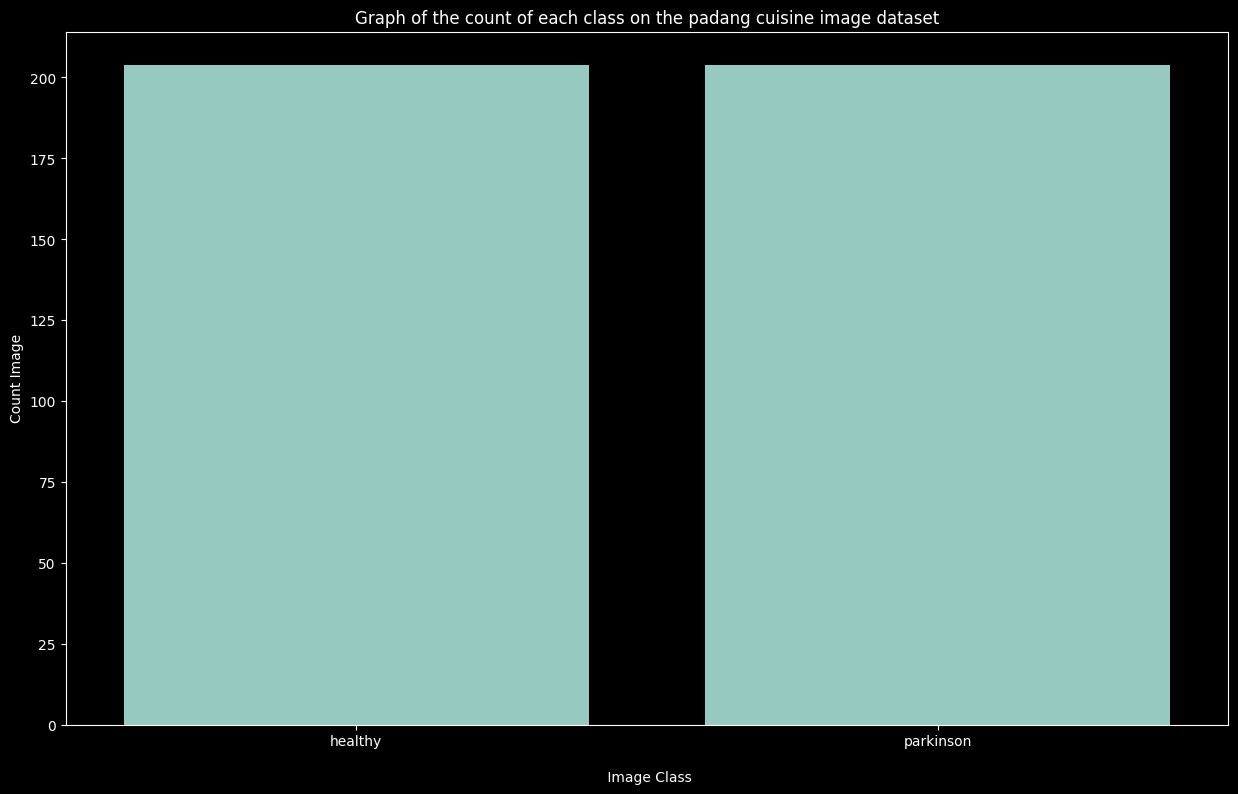

In [7]:
fig, ax = plt.subplots(figsize=(15,9))
sns.countplot(data=df, x='Class')
plt.title('Graph of the count of each class on the padang cuisine image dataset')
plt.xlabel('\n Image Class')
plt.ylabel('Count Image')

Data distibutions of Parkinsons image

In [8]:

Class_Id_Dist_Total = df['Class'].value_counts(sort=False)

import plotly.express as px
fig=px.pie(values=Class_Id_Dist_Total.values, names=Class_Id_Dist_Total.index, hole=0.500)
fig.update_layout(title='Data Distribution of Parkinson Image Dataset',font_size=15,title_x=0.45,annotations=[dict(text='Parkinson Image Dataset',font_size=12, showarrow=False,height=500,width=500)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

In [9]:
directories = {
    'Parkinson': [
        '/kaggle/input/parkinsons-drawings/spiral/training/parkinson/',
        '/kaggle/input/parkinsons-drawings/spiral/testing/parkinson/',
        '/kaggle/input/parkinsons-drawings/wave/training/parkinson/',
        '/kaggle/input/parkinsons-drawings/wave/testing/parkinson/'
    ],
    'Healthy': [
        '/kaggle/input/parkinsons-drawings/spiral/training/healthy/',
        '/kaggle/input/parkinsons-drawings/spiral/testing/healthy/',
        '/kaggle/input/parkinsons-drawings/wave/training/healthy/',
        '/kaggle/input/parkinsons-drawings/wave/testing/healthy/'
    ]
}


def get_dims(file):
    im = Image.open(file)
    arr = np.array(im)
    if len(arr.shape) == 3:
        h, w, d = arr.shape
    else:
        h, w = arr.shape
    return h, w

# Function to get all image files from multiple directories
def get_all_files(dir_list):
    all_files = []
    for directory in dir_list:
        if os.path.exists(directory):
            files = [os.path.join(directory, f) for f in os.listdir(directory)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            all_files.extend(files)
    return all_files


In [11]:
def load_all_data():
    """
    Function to load all images from drawings folder (spiral and wave)
    Returns organized data for both training and testing sets
    """

    # Define base paths
    base_path = Path("/root/.cache/kagglehub/datasets/kmader/parkinsons-drawings/versions/1")

    # Initialize data storage
    all_data = {
        'spiral': {
            'train': {'paths': [], 'labels': []},
            'test': {'paths': [], 'labels': []}
        },
        'wave': {
            'train': {'paths': [], 'labels': []},
            'test': {'paths': [], 'labels': []}
        }
    }

    # Load spiral data
    spiral_train_path = base_path / "spiral" / "training"
    spiral_test_path = base_path / "spiral" / "testing"

    # Get spiral training data
    if spiral_train_path.exists():
        spiral_train_files = list(spiral_train_path.glob("*/*.png"))
        all_data['spiral']['train']['paths'] = [str(p) for p in spiral_train_files]
        all_data['spiral']['train']['labels'] = [p.parent.name for p in spiral_train_files]

    # Get spiral testing data
    if spiral_test_path.exists():
        spiral_test_files = list(spiral_test_path.glob("*/*.png"))
        all_data['spiral']['test']['paths'] = [str(p) for p in spiral_test_files]
        all_data['spiral']['test']['labels'] = [p.parent.name for p in spiral_test_files]

    # Load wave data
    wave_train_path = base_path / "wave" / "training"
    wave_test_path = base_path / "wave" / "testing"

    # Get wave training data
    if wave_train_path.exists():
        wave_train_files = list(wave_train_path.glob("*/*.png"))
        all_data['wave']['train']['paths'] = [str(p) for p in wave_train_files]
        all_data['wave']['train']['labels'] = [p.parent.name for p in wave_train_files]

    # Get wave testing data
    if wave_test_path.exists():
        wave_test_files = list(wave_test_path.glob("*/*.png"))
        all_data['wave']['test']['paths'] = [str(p) for p in wave_test_files]
        all_data['wave']['test']['labels'] = [p.parent.name for p in wave_test_files]

    return all_data

def create_dataframes_from_data(data):
    """
    Convert loaded data into pandas DataFrames
    """
    dataframes = {}

    for drawing_type in ['spiral', 'wave']:
        for split in ['train', 'test']:
            if data[drawing_type][split]['paths']:
                df_name = f"{drawing_type}_{split}"
                dataframes[df_name] = pd.DataFrame({
                    'PNG': data[drawing_type][split]['paths'],
                    'CATEGORY': data[drawing_type][split]['labels']
                })

    return dataframes

def get_all_images_by_class():
    """
    Get all images organized by class (Healthy vs Parkinson)
    """
    data = load_all_data()

    healthy_images = []
    parkinson_images = []

    for drawing_type in ['spiral', 'wave']:
        for split in ['train', 'test']:
            paths = data[drawing_type][split]['paths']
            labels = data[drawing_type][split]['labels']

            for path, label in zip(paths, labels):
                if label.lower() == 'healthy':
                    healthy_images.append(path)
                elif label.lower() == 'parkinson':
                    parkinson_images.append(path)

    return {
        'Healthy': healthy_images,
        'Parkinson': parkinson_images
    }

# Load all data
print("Loading all data from drawings folder...")
all_image_data = load_all_data()
image_dataframes = create_dataframes_from_data(all_image_data)
images_by_class = get_all_images_by_class()

# Display summary
print(f"\nData Summary:")
for drawing_type in ['spiral', 'wave']:
    for split in ['train', 'test']:
        count = len(all_image_data[drawing_type][split]['paths'])
        print(f"{drawing_type.capitalize()} {split}: {count} images")

print(f"\nBy Class:")
print(f"Healthy: {len(images_by_class['Healthy'])} images")
print(f"Parkinson: {len(images_by_class['Parkinson'])} images")

Loading all data from drawings folder...

Data Summary:
Spiral train: 72 images
Spiral test: 30 images
Wave train: 72 images
Wave test: 30 images

By Class:
Healthy: 102 images
Parkinson: 102 images



Processing Healthy class with 102 images...
[########################################] | 100% Completed | 2.28 s


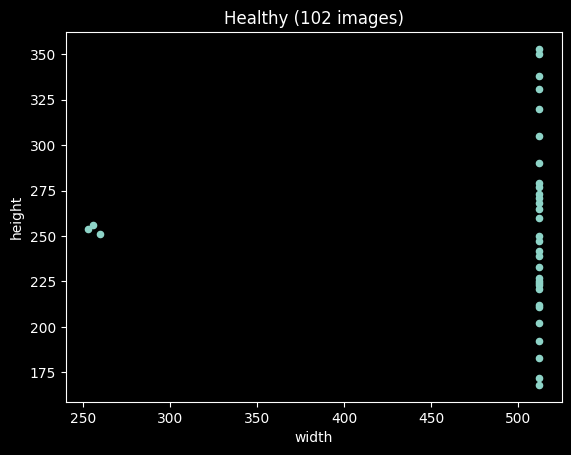


Processing Parkinson class with 102 images...
[########################################] | 100% Completed | 1.24 s


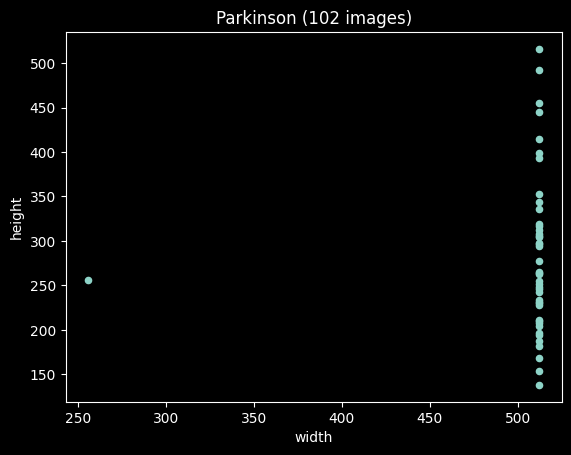

In [12]:
for class_name, image_files in images_by_class.items():
    if image_files:
        print(f"\nProcessing {class_name} class with {len(image_files)} images...")

        dims = db.from_sequence(image_files).map(get_dims)

        with ProgressBar():
            dims = dims.compute()
            dim_df = pd.DataFrame(dims, columns=['height', 'width'])
            dim_df['file_path'] = image_files

            # Original plot for all images
            sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
            sizes.plot.scatter(x='width', y='height')
            plt.title('{} ({} images)'.format(class_name, len(image_files)))
            plt.show()
    else:
        print(f"No images found for {class_name}")

In [13]:
# Using the new data loading function
Main_Spiral_Train_Data = image_dataframes['spiral_train'].copy()
Main_Spiral_Test_Data = image_dataframes['spiral_test'].copy()

print("Spiral Training Data:")
print(Main_Spiral_Train_Data.head(-1))
print(f"\nSpiral Training Data Shape: {Main_Spiral_Train_Data.shape}")

print("\nSpiral Testing Data:")
print(Main_Spiral_Test_Data.head())
print(f"Spiral Testing Data Shape: {Main_Spiral_Test_Data.shape}")

# Also create Wave data for later use
if 'wave_train' in image_dataframes:
    Main_Wave_Train_Data = image_dataframes['wave_train'].copy()
    print(f"\nWave Training Data Shape: {Main_Wave_Train_Data.shape}")

if 'wave_test' in image_dataframes:
    Main_Wave_Test_Data = image_dataframes['wave_test'].copy()
    print(f"Wave Testing Data Shape: {Main_Wave_Test_Data.shape}")

Spiral Training Data:
                                                  PNG   CATEGORY
0   /root/.cache/kagglehub/datasets/kmader/parkins...    healthy
1   /root/.cache/kagglehub/datasets/kmader/parkins...    healthy
2   /root/.cache/kagglehub/datasets/kmader/parkins...    healthy
3   /root/.cache/kagglehub/datasets/kmader/parkins...    healthy
4   /root/.cache/kagglehub/datasets/kmader/parkins...    healthy
..                                                ...        ...
66  /root/.cache/kagglehub/datasets/kmader/parkins...  parkinson
67  /root/.cache/kagglehub/datasets/kmader/parkins...  parkinson
68  /root/.cache/kagglehub/datasets/kmader/parkins...  parkinson
69  /root/.cache/kagglehub/datasets/kmader/parkins...  parkinson
70  /root/.cache/kagglehub/datasets/kmader/parkins...  parkinson

[71 rows x 2 columns]

Spiral Training Data Shape: (72, 2)

Spiral Testing Data:
                                                 PNG CATEGORY
0  /root/.cache/kagglehub/datasets/kmader/parkins...  

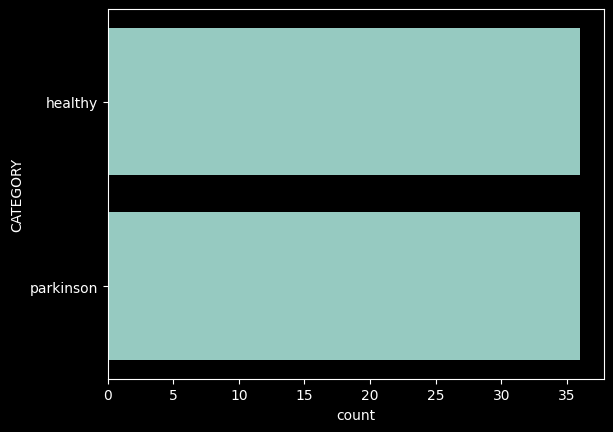

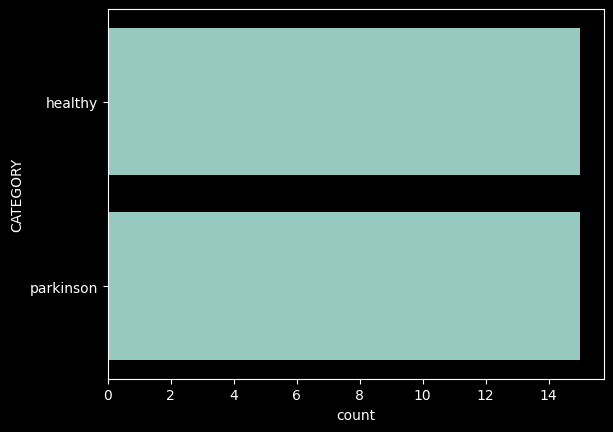

In [14]:
sns.countplot(Main_Spiral_Train_Data["CATEGORY"])
plt.show()

sns.countplot(Main_Spiral_Test_Data["CATEGORY"])
plt.show()

Text(0.5, 1.0, 'healthy')

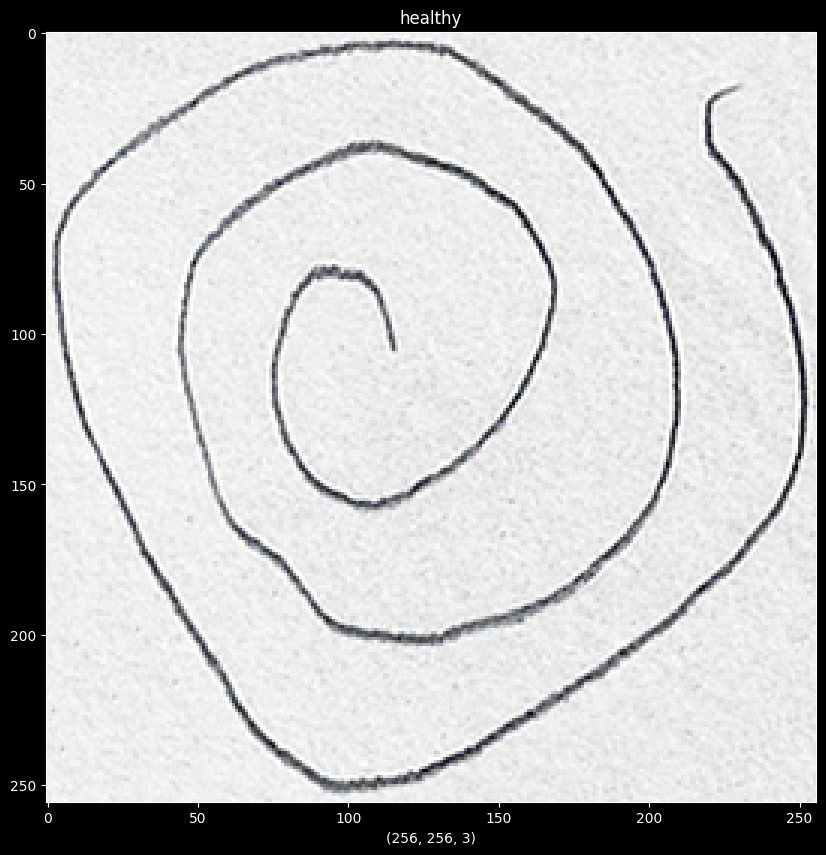

In [15]:
figure = plt.figure(figsize=(10,10))
x = plt.imread(Main_Spiral_Train_Data["PNG"][0])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(Main_Spiral_Train_Data["CATEGORY"][0])

Text(0.5, 1.0, 'healthy')

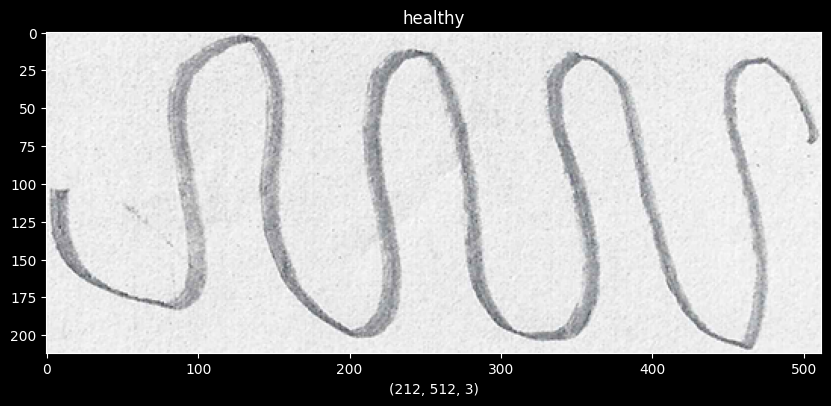

In [16]:
figure = plt.figure(figsize=(10,10))
x = plt.imread(Main_Wave_Test_Data["PNG"][0])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(Main_Wave_Test_Data["CATEGORY"][0])

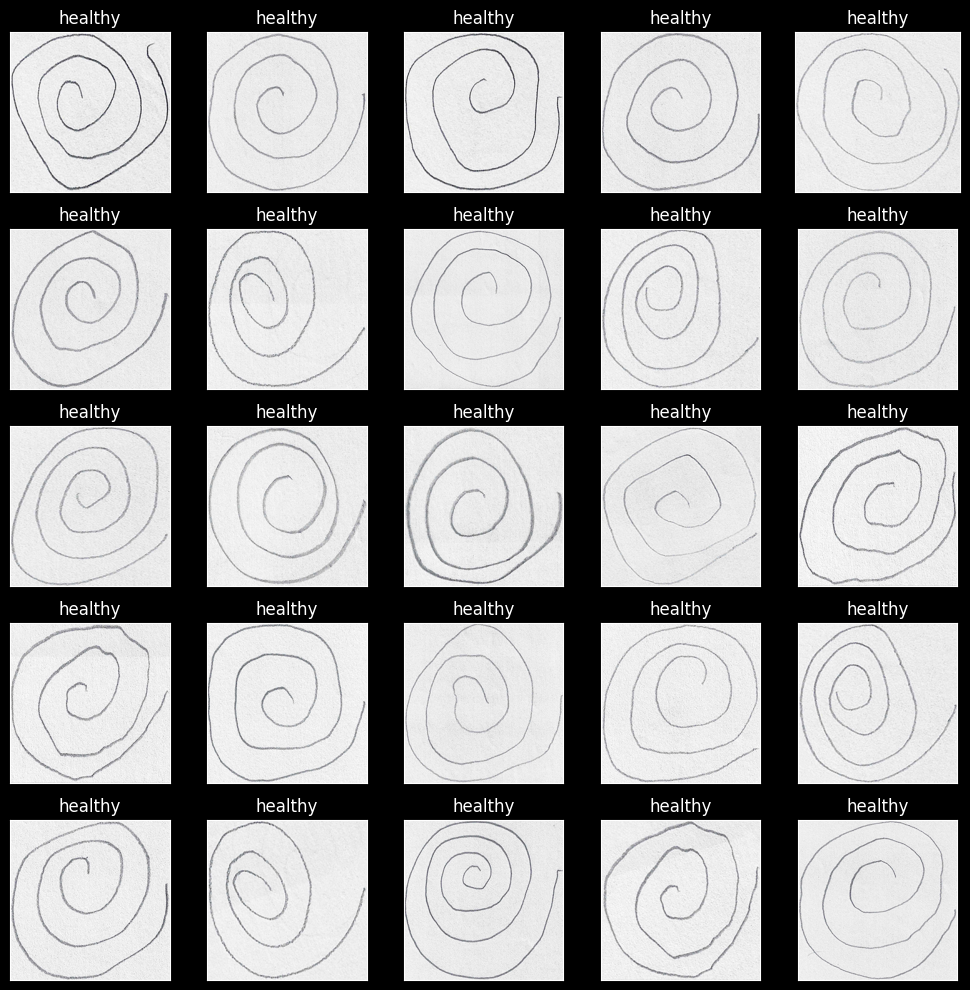

In [17]:
fig, axes = plt.subplots(nrows=5,
                        ncols=5,
                        figsize=(10,10),
                        subplot_kw={"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Spiral_Train_Data["PNG"][i]))
    ax.set_title(Main_Spiral_Train_Data["CATEGORY"][i])
plt.tight_layout()
plt.show()

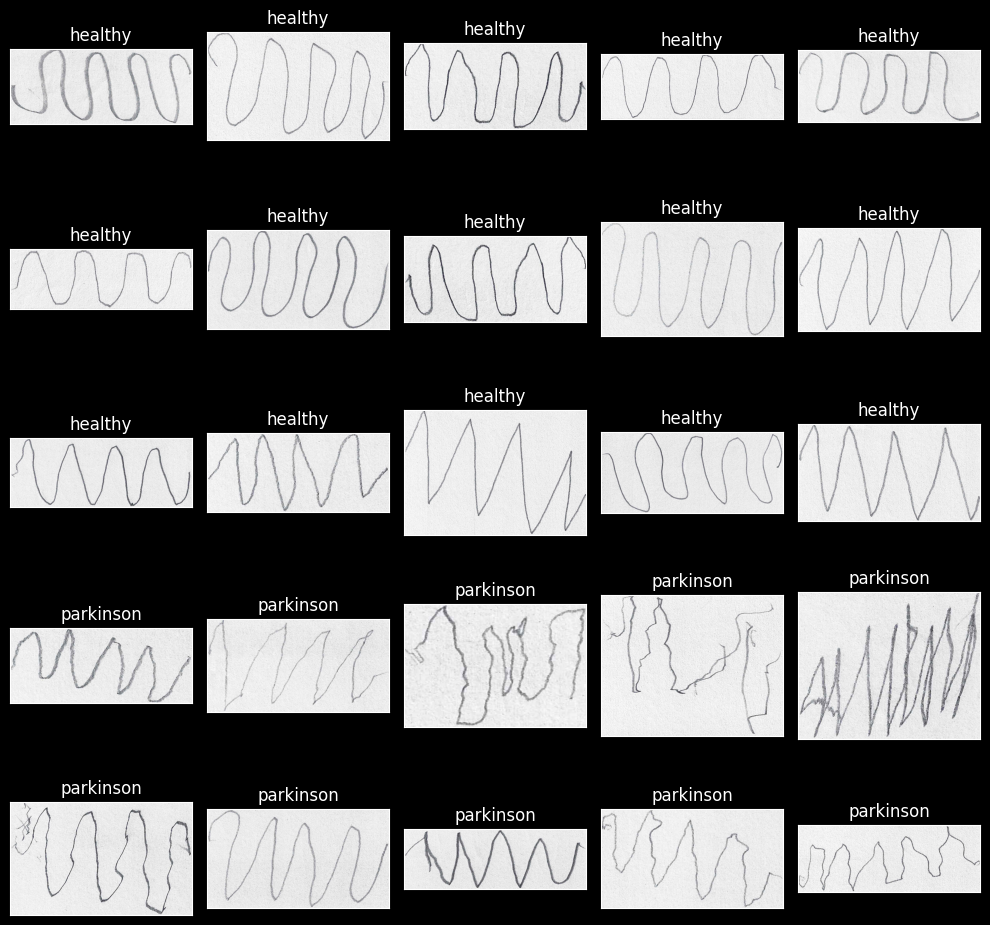

In [18]:
fig, axes = plt.subplots(nrows=5,
                        ncols=5,
                        figsize=(10,10),
                        subplot_kw={"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Wave_Test_Data["PNG"][i]))
    ax.set_title(Main_Wave_Test_Data["CATEGORY"][i])
plt.tight_layout()
plt.show()

In [19]:
def quantify_image(image):
    features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                           transform_sqrt=True, block_norm="L1")
    return features

In [20]:
def load_split(drawing_type='spiral', split='train'):
    """
    Load and process images for the specified drawing type and split
    drawing_type: 'spiral' or 'wave'
    split: 'train' or 'test'
    """
    # Get data using our new function
    data_key = f"{drawing_type}_{split}"

    if data_key not in image_dataframes:
        print(f"No data found for {drawing_type} {split}")
        return (np.array([]), np.array([]))

    df = image_dataframes[data_key]
    data = []
    labels = []

    # Loop over the image paths
    for idx, row in df.iterrows():
        imagePath = row['PNG']
        label = row['CATEGORY']

        # Load the input image, convert it to grayscale, and resize
        # it to 200x200 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        if image is None:
            print(f"Warning: Could not load image {imagePath}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))

        # Threshold the image such that the drawing appears as white
        # on a black background
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        # Quantify the image
        features = quantify_image(image)

        # Update the data and labels lists, respectively
        data.append(features)
        labels.append(label)

    return (np.array(data), np.array(labels))


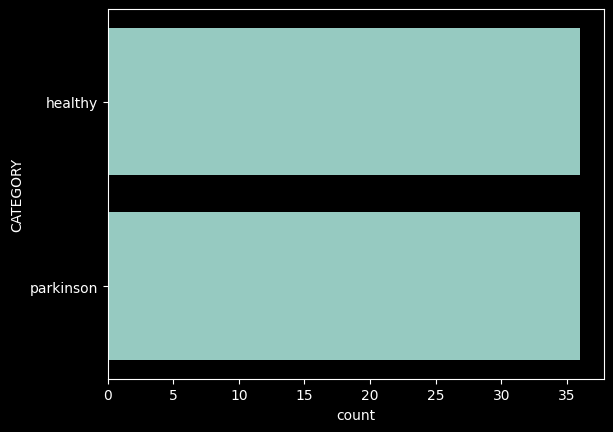

In [21]:
plt.style.use("dark_background")

sns.countplot(Main_Spiral_Train_Data["CATEGORY"])
plt.show()

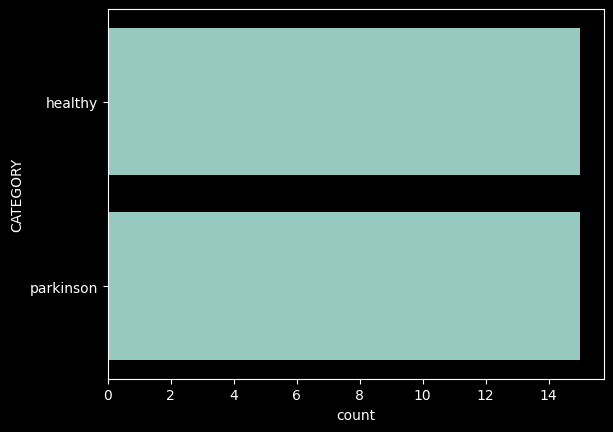

In [22]:
sns.countplot(Main_Spiral_Test_Data["CATEGORY"])
plt.show()

In [23]:
!pip install imutils
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

In [24]:
def train_models(dataset):
    """
    Train models using the new data loading function
    dataset: 'spiral' or 'wave'
    """
    # initialize the models
    models = {
        "Rf": {
            "classifier": RandomForestClassifier(random_state=1),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
        },
        "Xgb": {
            "classifier": XGBClassifier(),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
        }
    }

    # Load the data using our new function
    print(f"Loading {dataset} training data...")
    (trainX, trainY) = load_split(dataset, 'train')
    print(f"Loading {dataset} testing data...")
    (testX, testY) = load_split(dataset, 'test')

    if len(trainX) == 0 or len(testX) == 0:
        print(f"Error: No data found for {dataset}")
        return models

    print(f"Training data shape: {trainX.shape}")
    print(f"Testing data shape: {testX.shape}")

    # encode the labels
    le = LabelEncoder()
    trainY = le.fit_transform(trainY)
    testY = le.transform(testY)

    print(f"Label classes: {le.classes_}")

    # train each model and calculate its metrics
    for model in models:
        print(f"Training {model} model...")
        models[model]["classifier"].fit(trainX, trainY)
        predictions = models[model]["classifier"].predict(testX)
        cm = confusion_matrix(testY, predictions).ravel()

        if len(cm) == 4:
            tn, fp, fn, tp = cm
            models[model]["accuracy"] = (tp + tn) / float(cm.sum())
            models[model]["sensitivity"] = tp / float(tp + fn)
            models[model]["specificity"] = tn / float(tn + fp)
        else:
            print(f"Warning: Unexpected confusion matrix shape for {model}")

    return models

In [25]:
# Train the models on the spiral drawings
spiralModels = train_models('spiral')

Loading spiral training data...
Loading spiral testing data...
Training data shape: (72, 12996)
Testing data shape: (30, 12996)
Label classes: ['healthy' 'parkinson']
Training Rf model...
Training Xgb model...


In [26]:
# train the model on the wave-form drawings
waveModels = train_models('wave')

Loading wave training data...
Loading wave testing data...
Training data shape: (72, 12996)
Testing data shape: (30, 12996)
Label classes: ['healthy' 'parkinson']
Training Rf model...
Training Xgb model...


In [27]:
print("Random Forrest vs XGBoost Classifier\n\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% \n".format(
        spiralModels['Rf'][metric]*100, spiralModels['Xgb'][metric]*100))

Random Forrest vs XGBoost Classifier


Accuracy: 
Random Forrest=83.33%, XGBoost=73.33% 

Sensitivity: 
Random Forrest=73.33%, XGBoost=73.33% 

Specificity: 
Random Forrest=93.33%, XGBoost=73.33% 



In [28]:
print("Random Forrest vs XGBoost Classifier\n\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% \n".format(
        waveModels['Rf'][metric]*100, waveModels['Xgb'][metric]*100))

Random Forrest vs XGBoost Classifier


Accuracy: 
Random Forrest=63.33%, XGBoost=73.33% 

Sensitivity: 
Random Forrest=60.00%, XGBoost=80.00% 

Specificity: 
Random Forrest=66.67%, XGBoost=66.67% 



In [29]:
def test_prediction(model, testingPath):
    # get the list of images
    testingPaths = list(paths.list_images(testingPath))
    output_images = []
    # pick 15 images at random
    for _ in range(15):
        image = cv2.imread(random.choice(testingPaths))
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        # pre-process the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image and make predictions based on the extracted features
        features = quantify_image(image)
        preds = model.predict([features])
        label = "Parkinsons" if preds[0] else "Healthy"

        # draw the colored class label on the output image and add it to
        # the set of output images
        color = (0, 255, 0) if label == "Healthy" else (0, 0, 255)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)
        output_images.append(output)
    plt.figure(figsize=(20, 20))
    for i in range(len(output_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(output_images[i])
        plt.axis("off")
    plt.show()

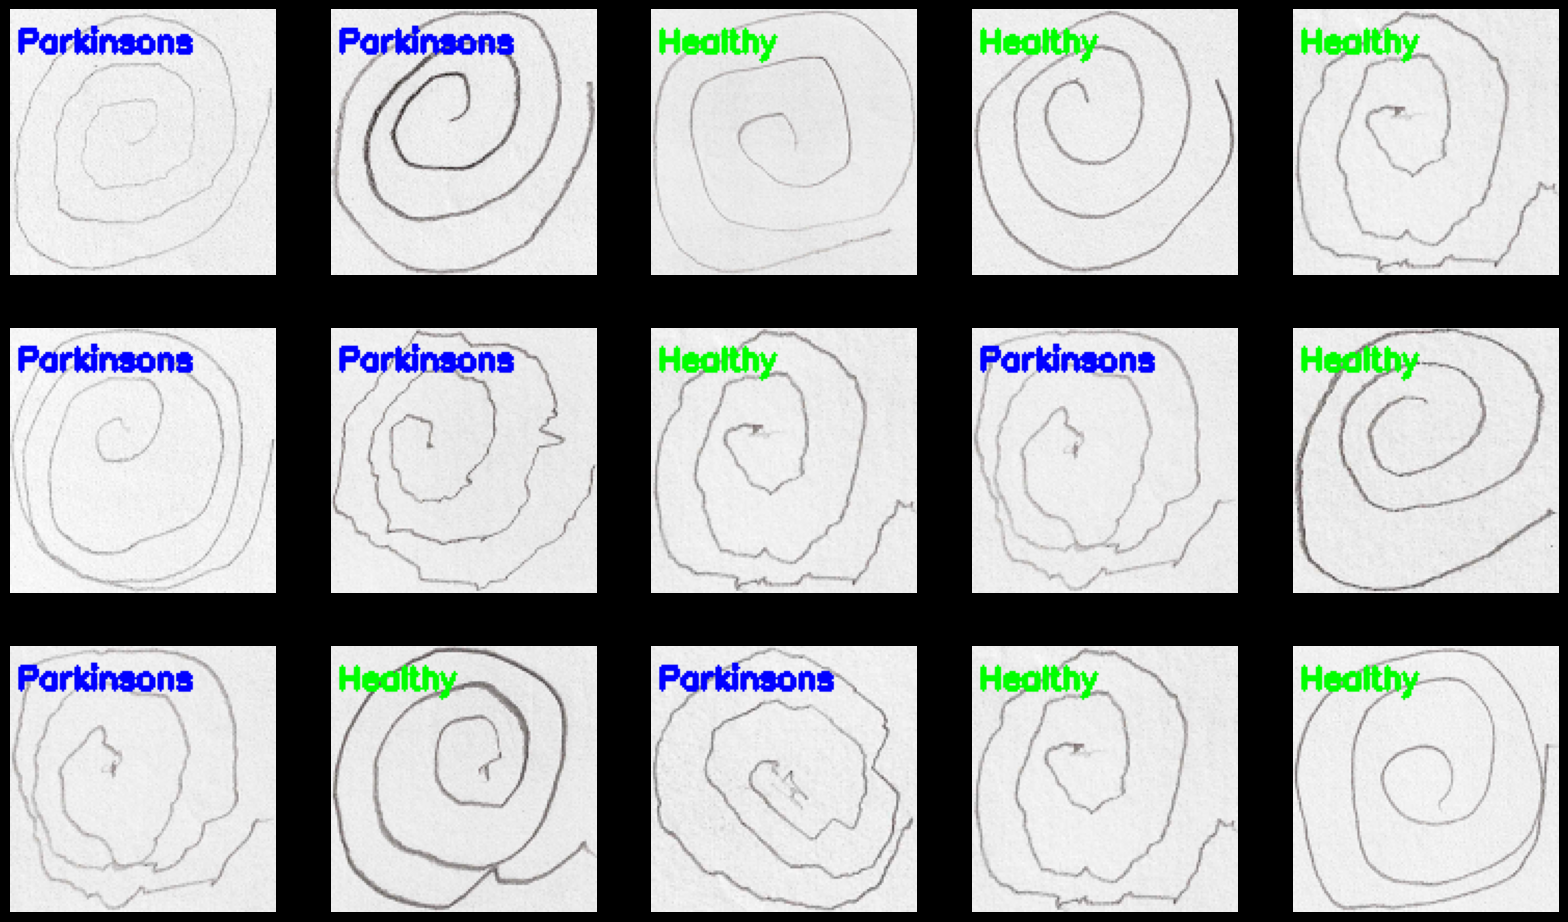

In [31]:
from pathlib import Path
import os

# Correct base path (KaggleHub or local cache)
base_path = Path("/root/.cache/kagglehub/datasets/kmader/parkinsons-drawings/versions/1")

# Use base_path to build the correct testing directory
testingPath = base_path / "spiral" / "testing"

# Now pass it properly
test_prediction(spiralModels['Rf']['classifier'], str(testingPath))


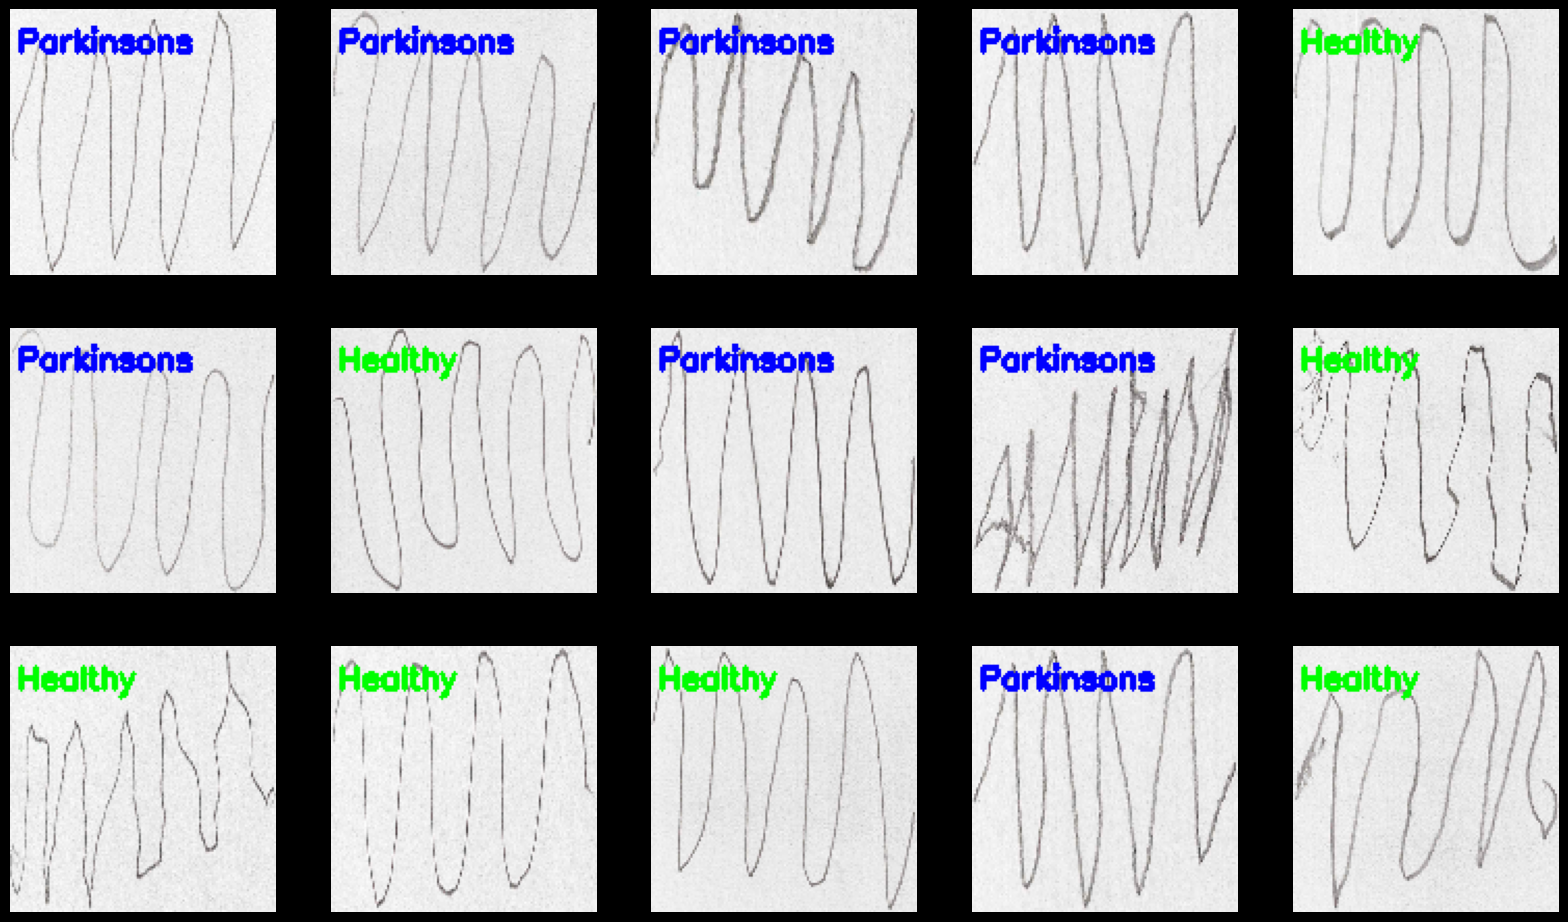

In [32]:
from pathlib import Path
import os

# Base path for KaggleHub/local dataset
base_path = Path("/root/.cache/kagglehub/datasets/kmader/parkinsons-drawings/versions/1")

# Correct path for wave testing data
testingPath = base_path / "wave" / "testing"

# Convert to string before passing if needed
test_prediction(waveModels['Rf']['classifier'], str(testingPath))
